<a href="https://colab.research.google.com/github/JPP-J/DL-3_RAG/blob/main/DEMO_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RAG (Retrieval-Augmented Generation)
technique that combines information retrieval with natural language generation to improve the quality and relevance of generated text, especially for question answering, chatbots, and knowledge-intensive tasks.



## RAG architecture combines:

- Retriever: Fetches relevant documents or passages from a corpus using a similarity search (e.g., FAISS with dense vector embeddings).

- Generator: Uses a language model (e.g., T5) to generate responses based on the retrieved documents and the input query.

## Install dependencies

In [ ]:
! pip install faiss-cpu
! pip install sentence-transformers
! pip install transformers
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
! pip list | grep fa

faiss-cpu                             1.11.0
fastai                                2.7.19
fastapi                               0.115.12
fastcore                              1.7.29
fastdownload                          0.0.7
fastjsonschema                        2.21.1
fastprogress                          1.0.3
fastrlock                             0.8.3
huggingface-hub                       0.32.2
keyrings.google-artifactregistry-auth 1.1.2
pyerfa                                2.0.1.5


## Main Fucntion

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import torch
from transformers import pipeline
import re


def create_faiss_index(texts, embedding_model="all-MiniLM-L6-v2"):

  model = SentenceTransformer(embedding_model)
  embeddings = model.encode(texts, convert_to_tensor=False)

  index = faiss.IndexFlatL2(embeddings[0].shape[0])
  index.add(np.array(embeddings))

  return index, model

def query_index(query, model, index):
  query_vector = model.encode([query])
  D, I = index.search(np.array(query_vector), k=2)  # distances, indices
  retrieved_docs = [texts[i] for i in I[0]]

  return retrieved_docs, query

def use_gpu():
  if torch.cuda.is_available():
    device = torch.device("cuda")
  else:
    device = torch.device("cpu")

def get_result(response, query):
  answer = response[0]['generated_text']
  print("Question:", query)
  print("Answer:", answer)


def generate_answer(retrieved_docs, query, task="text2text-generation", generator_model="valhalla/t5-small-qa-qg-hl"):
  use_gpu()
  generator = pipeline(task, model=generator_model, device=0)
  input_text = f"question: {query} context: {' '.join(retrieved_docs)}"
  response = generator(input_text, max_new_tokens=1024)

  return response


def main_rag(query, index, model_embedded, generator_model):
  # index, model = create_faiss_index(texts, embedding_model)
  retrieved_docs, query = query_index(query, model_embedded, index)
  response = generate_answer(retrieved_docs, query, generator_model=generator_model)

  return response


## List of model

In [ ]:
model_eb1 = "all-MiniLM-L6-v2"
model_eb2 = "all-distilroberta-v1"
model_eb3 = "all-MiniLM-L12-v2"
model_g1 = "valhalla/t5-small-qa-qg-hl"
task_g1 = "text2text-generation"

## Upload or load documents


In [ ]:
texts = [
    # Geography
    "Mount Everest is the highest mountain in the world, located in the Himalayas.",
    "The Amazon River is one of the longest rivers on Earth, flowing through South America.",

    # Science
    "Photosynthesis is the process by which green plants convert sunlight into chemical energy.",
    "Albert Einstein developed the theory of relativity, revolutionizing modern physics.",

    # Technology
    "Blockchain is a decentralized ledger technology used in cryptocurrencies like Bitcoin.",
    "Machine learning is a subset of artificial intelligence that focuses on pattern recognition and prediction.",

    # History
    "The French Revolution began in 1789 and led to major political and social changes in France.",
    "The Roman Empire was one of the most powerful civilizations in history, lasting for over a thousand years.",

    # Health
    "The human immune system defends the body against infectious diseases and harmful invaders.",
    "Cardiovascular exercise helps improve heart health and overall physical endurance.",

    # Literature
    "William Shakespeare was an English playwright and poet, known for works like 'Hamlet' and 'Romeo and Juliet'.",
    "George Orwell's '1984' is a dystopian novel exploring themes of surveillance and authoritarianism.",

    # Space
    "The James Webb Space Telescope is designed to study the formation of stars and galaxies.",
    "Mars is often called the Red Planet due to its iron oxide-rich soil."
]


## Embed documents into vector DB (e.g., FAISS)


In [ ]:
texts = texts
embedding_model = model_eb1
generator_model = model_g1

index, model = create_faiss_index(texts, embedding_model)

# Model Usage
- For embedding model: all-MiniLM-L6-v2
- For text generator: valhalla/t5-small-qa-qg-hl


In [ ]:
generator_model

'valhalla/t5-small-qa-qg-hl'

## Example Usage
According to context addded above then ask about those context show as below:
- Ask a question
- Retrieve relevant
- Use an LLM to generate answer from retrieved text

In [ ]:
query = "What is the highest mountain in the world?"
response = main_rag(query, index, model_embedded=model, generator_model=generator_model)
get_result(response, query)

Device set to use cuda:0


Question: What is the highest mountain in the world?
Answer: Mount Everest


In [ ]:
query = "How do plants make their own food?"
response = main_rag(query, index, model_embedded=model, generator_model=generator_model)
get_result(response, query)

Device set to use cuda:0


Question: How do plants make their own food?
Answer: convert sunlight into chemical energy


In [ ]:
query = "What is blockchain used for?"
response = main_rag(query, index, model_embedded=model, generator_model=generator_model)
get_result(response, query)

Device set to use cuda:0


Question: What is blockchain used for?
Answer: cryptocurrencies


In [ ]:
query = "When did the French Revolution start?"
response = main_rag(query, index, model_embedded=model, generator_model=generator_model)
get_result(response, query)

Device set to use cuda:0


Question: When did the French Revolution start?
Answer: 1789


In [ ]:
query = "What are the benefits of cardiovascular exercise?"
response = main_rag(query, index, model_embedded=model, generator_model=generator_model)
get_result(response, query)

Device set to use cuda:0


Question: What are the benefits of cardiovascular exercise?
Answer: improve heart health and overall physical endurance


In [ ]:
query = "Who wrote Romeo and Juliet ?"

response = main_rag(query, index, model_embedded=model, generator_model=generator_model)
get_result(response, query)

Device set to use cuda:0


Question: Who wrote Romeo and Juliet ?
Answer: William Shakespeare


In [ ]:
query = "Why is Mars called the Red Planet?"
response = main_rag(query, index, model_embedded=model, generator_model=generator_model)
get_result(response, query)

Device set to use cuda:0


Question: Why is Mars called the Red Planet?
Answer: iron oxide-rich soil


# Python files in project
This section briefly explains the purpose and role of each key Python module in the project.

### 🖼️ `utils/ui.py`

**Purpose**: Provides a web interface using Gradio for interactive question answering.

**Key Functions**:
- `main_ui()`: Launches the Gradio app, connects user input to `response_answer_gr()` for live interaction.

---


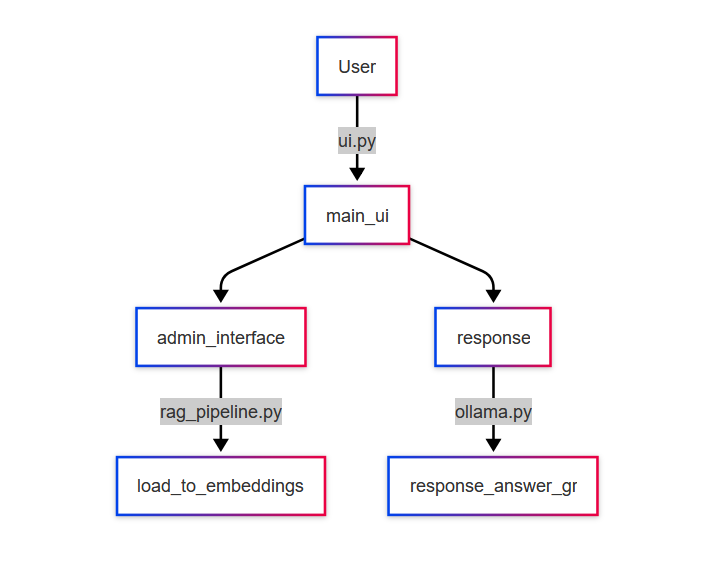 


### 🧠 `utils/rag_pipeline.py`

**Purpose**: Handles document loading, chunking, and vector embedding for Retrieval-Augmented Generation (RAG).

**Key Functions**:
- `load_text_file(file_path)`: Loads a single text file into a `Document`.
- `load_folder_documents(doc_folder)`: Loads all `.txt` files from a folder.
- `split_text(doc)`: Splits a single `Document` into chunks.
- `split_documents(docs)`: Splits multiple documents into chunks.
- `embed_documents(chunks)`: Embeds chunks with a HuggingFace model and saves to FAISS.
- `load_to_embeddings(mode, path)`: Controls document load mode (file or folder) and calls embedding.
- `load_or_create_vectorstore()`: Loads an existing FAISS index or creates a new one.

---

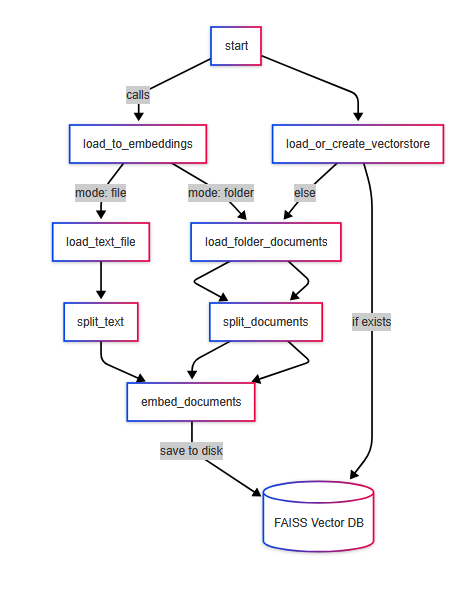

### 🤖 `utils/ollama.py`

**Purpose**: Manages prompt creation, model response generation using Ollama, and chat history storage.

**Key Functions**:
- `stream_ollama_response(prompt)`: Streams response text from Ollama model.
- `build_prompt(query, context_chunks, messages)`: Builds a structured prompt from user query, context, and history.
- `load_all_chat_histories(folder)`: Loads recent chat sessions (JSON) for prompt context.
- `save_chat(messages, folder_path)`: Saves chat history.
- `limit_history(messages, max_turns)`: Trims old messages to retain relevant context.
- `response_answer()`: Console interface for asking and answering questions.
- `response_answer_gr(query)`: Generator that returns answers for Gradio UI integration.

---

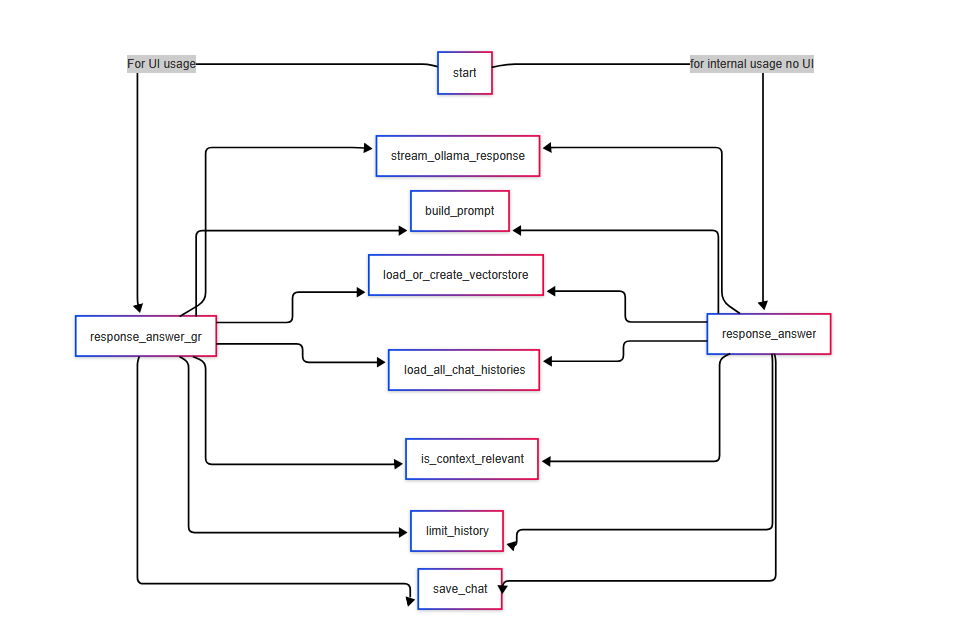

### 🚀 `main.py`

**Purpose**: Entry point to start the application.

**Behavior**:
- Uncomment `load_to_embeddings()` to load and embed documents before querying.
- Uncomment `response_answer()` for a CLI (non-UI) version.
- Runs `main_ui()` by default to start the Gradio web interface.

---

